In [ ]:
# ==========================================
# Test Fine-tuned RoBERTa on New Dataset
# ==========================================

import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("Testing Fine-tuned RoBERTa on New Dataset")
print("="*70)

# ==========================================
# Load Fine-tuned Model
# ==========================================
print("\n📥 Loading your fine-tuned RoBERTa model...")
print("Model path: ./fine_tuned_roberta")

import torch
device = 0 if torch.cuda.is_available() else -1  # 0 = GPU, -1 = CPU

# Load your fine-tuned model
classifier = pipeline(
    'sentiment-analysis',
    model='./fine_tuned_roberta',
    device=device
)

if device == 0:
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Using CPU (GPU not available)")

print("✓ Fine-tuned model loaded successfully!")

# ==========================================
# Load New Test Dataset
# ==========================================
print("\n📂 Loading new test dataset...")

# Load the new dataset
df = pd.read_csv('cleaned_sentiment_data.csv')
print(f"✓ Loaded {len(df)} samples")
print(f"\nColumns: {df.columns.tolist()}")

# Handle column names
if 'clean_text' in df.columns:
    df = df.rename(columns={'clean_text': 'text'})
if 'target' in df.columns:
    df = df.rename(columns={'target': 'actual_label'})

# If columns are unnamed, assume first is label, second is text
if 'text' not in df.columns and len(df.columns) == 2:
    df.columns = ['actual_label', 'text']

print(f"\nFirst few rows:")
print(df.head())

print(f"\nDataset shape: {df.shape}")
print(f"Text column sample length: {df['text'].str.len().mean():.0f} characters (avg)")

# Check if we have labels
has_labels = 'actual_label' in df.columns
if has_labels:
    print(f"\n✓ Labels found - will calculate accuracy")
    print(f"Label distribution:\n{df['actual_label'].value_counts()}")
else:
    print(f"\n⚠️ No labels found - will only make predictions")

# ==========================================
# Make Predictions with Fine-tuned Model
# ==========================================
print("\n🔮 Making predictions with your fine-tuned model...")
print("(Processing on GPU...)\n")

# For GPU optimization
if device == 0:
    print("🚀 Using GPU-optimized batch processing...")

    # Convert to list
    all_texts = df['text'].tolist()

    # Predict with larger batch size on GPU
    results = classifier(
        all_texts,
        batch_size=128,
        truncation=True,
        max_length=512
    )

    # Extract predictions
    predictions = []
    confidences = []

    print("Processing predictions...")
    for result in results:
        label = result['label']
        score = result['score']

        # Convert LABEL_0 -> 0 (negative), LABEL_1 -> 1 (positive)
        if 'LABEL_0' in label or label == '0':
            pred = 0
        elif 'LABEL_1' in label or label == '1':
            pred = 1
        elif 'negative' in label.lower():
            pred = 0
        else:
            pred = 1

        predictions.append(pred)
        confidences.append(score)

    print(f"✓ Processed {len(predictions)} predictions")

else:
    # CPU processing
    print("Using CPU batch processing...")
    predictions = []
    confidences = []

    batch_size = 32

    for i in tqdm(range(0, len(df), batch_size), desc="Predicting"):
        batch = df['text'][i:i+batch_size].tolist()
        results = classifier(batch, truncation=True, max_length=512)

        for result in results:
            label = result['label']
            score = result['score']

            # Convert to binary
            if 'LABEL_0' in label or label == '0' or 'negative' in label.lower():
                pred = 0
            else:
                pred = 1

            predictions.append(pred)
            confidences.append(score)

# Add predictions to dataframe
df['predicted_label'] = predictions
df['confidence'] = confidences

print("\n✓ Predictions completed!")
print(f"\nPrediction distribution:")
print(df['predicted_label'].value_counts())

# ==========================================
# Calculate Accuracy (if labels available)
# ==========================================
if has_labels:
    print("\n📊 Calculating Accuracy...")

    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import numpy as np

    accuracy = accuracy_score(df['actual_label'], df['predicted_label'])

    print(f"\n{'='*70}")
    print(f"✨ ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%) ✨")
    print(f"{'='*70}")

    print("\n📈 Detailed Classification Report:")
    print(classification_report(df['actual_label'], df['predicted_label'],
                                target_names=['Negative', 'Positive']))

    print("\n🔢 Confusion Matrix:")
    cm = confusion_matrix(df['actual_label'], df['predicted_label'])
    cm_df = pd.DataFrame(cm,
                         columns=['Predicted Negative', 'Predicted Positive'],
                         index=['Actual Negative', 'Actual Positive'])
    print(cm_df)

    # Calculate additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score

    precision = precision_score(df['actual_label'], df['predicted_label'])
    recall = recall_score(df['actual_label'], df['predicted_label'])
    f1 = f1_score(df['actual_label'], df['predicted_label'])

    print(f"\n📊 Additional Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    # Show correct and incorrect predictions
    print("\n" + "="*70)
    print("✅ Sample CORRECT Predictions:")
    print("="*70)
    correct = df[df['actual_label'] == df['predicted_label']].sample(min(5, len(df)))
    for idx, row in correct.iterrows():
        sentiment = "😊 Positive" if row['predicted_label'] == 1 else "😞 Negative"
        print(f"\n📝 Text: {row['text'][:150]}...")
        print(f"   Predicted: {sentiment} (confidence: {row['confidence']:.4f})")

    print("\n" + "="*70)
    print("❌ Sample INCORRECT Predictions:")
    print("="*70)
    incorrect_df = df[df['actual_label'] != df['predicted_label']]
    if len(incorrect_df) > 0:
        incorrect = incorrect_df.sample(min(5, len(incorrect_df)))
        for idx, row in incorrect.iterrows():
            actual_sent = "😊 Positive" if row['actual_label'] == 1 else "😞 Negative"
            pred_sent = "😊 Positive" if row['predicted_label'] == 1 else "😞 Negative"
            print(f"\n📝 Text: {row['text'][:150]}...")
            print(f"   Actual: {actual_sent} | Predicted: {pred_sent} (confidence: {row['confidence']:.4f})")
    else:
        print("\n🎉 No incorrect predictions! (Perfect accuracy)")

# ==========================================
# Visualize Results (if labels available)
# ==========================================
if has_labels:
    print("\n📊 Creating visualizations...")

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_style("whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[0, 0].set_title(f'Confusion Matrix\nAccuracy: {accuracy*100:.2f}%',
                         fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Actual', fontsize=12)
    axes[0, 0].set_xlabel('Predicted', fontsize=12)

    # 2. Confidence Distribution
    axes[0, 1].hist(df['confidence'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Confidence Score', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].axvline(df['confidence'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["confidence"].mean():.3f}')
    axes[0, 1].legend()

    # 3. Actual vs Predicted Distribution
    comparison = pd.DataFrame({
        'Actual': df['actual_label'].value_counts(),
        'Predicted': df['predicted_label'].value_counts()
    })
    comparison.plot(kind='bar', ax=axes[1, 0], color=['#FF6B6B', '#4ECDC4'])
    axes[1, 0].set_title('Actual vs Predicted Label Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Label (0=Negative, 1=Positive)', fontsize=12)
    axes[1, 0].set_ylabel('Count', fontsize=12)
    axes[1, 0].set_xticklabels(['Negative', 'Positive'], rotation=0)
    axes[1, 0].legend()

    # 4. Accuracy by Confidence Bins
    df['confidence_bin'] = pd.cut(df['confidence'], bins=[0, 0.5, 0.7, 0.9, 1.0],
                                   labels=['Low (0-0.5)', 'Medium (0.5-0.7)',
                                          'High (0.7-0.9)', 'Very High (0.9-1.0)'])
    accuracy_by_conf = df.groupby('confidence_bin').apply(
        lambda x: (x['actual_label'] == x['predicted_label']).mean()
    )
    accuracy_by_conf.plot(kind='bar', ax=axes[1, 1], color='#95E1D3')
    axes[1, 1].set_title('Accuracy by Confidence Level', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Confidence Bin', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy', fontsize=12)
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    axes[1, 1].axhline(accuracy, color='red', linestyle='--', label='Overall Accuracy')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('finetuned_model_test_results.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved as 'finetuned_model_test_results.png'")
    plt.show()

# ==========================================
# Save Results
# ==========================================
print(f"\n💾 Saving predictions...")

# Save predictions
df.to_csv('test_predictions_finetuned.csv', index=False)
print("✓ Predictions saved to: test_predictions_finetuned.csv")

# Save summary
if has_labels:
    summary = {
        'Total Samples': len(df),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Correct Predictions': (df['actual_label'] == df['predicted_label']).sum(),
        'Incorrect Predictions': (df['actual_label'] != df['predicted_label']).sum(),
        'Average Confidence': df['confidence'].mean(),
        'Negative Predictions': (df['predicted_label'] == 0).sum(),
        'Positive Predictions': (df['predicted_label'] == 1).sum()
    }

    summary_df = pd.DataFrame([summary])
    summary_df.to_csv('test_summary_finetuned.csv', index=False)
    print("✓ Summary saved to: test_summary_finetuned.csv")

# ==========================================
# Test on Custom Sentences
# ==========================================
print("\n" + "="*70)
print("🧪 Testing on Custom Sentences with Fine-tuned Model")
print("="*70)

test_sentences = [
    "I absolutely love this product! It's amazing!",
    "This is the worst experience I've ever had.",
    "The service was okay, nothing special.",
    "Fantastic! Best purchase ever!",
    "I'm so disappointed and frustrated with this.",
    "Not bad, could be better though.",
    "Awesome quality and fast delivery!",
    "Terrible customer service, would not recommend."
]

print("\n🔮 Predictions:\n")
for sentence in test_sentences:
    result = classifier(sentence)[0]
    label = result['label']
    score = result['score']

    # Convert to readable format
    if 'LABEL_0' in label or label == '0' or 'negative' in label.lower():
        sentiment = "😞 Negative"
    else:
        sentiment = "😊 Positive"

    print(f"📝 Text: {sentence}")
    print(f"   {sentiment} (confidence: {score:.4f})")
    print()

# ==========================================
# Final Summary
# ==========================================
print("="*70)
print("🎉 TESTING COMPLETED!")
print("="*70)
print(f"\n✅ Total predictions: {len(df):,}")
if has_labels:
    print(f"✅ Accuracy: {accuracy*100:.2f}%")
    print(f"✅ F1-Score: {f1:.4f}")
    print(f"✅ Average confidence: {df['confidence'].mean():.4f}")
print(f"✅ Results saved: test_predictions_finetuned.csv")
print("\n" + "="*70)

# Show final preview
print("\n📊 Final Results Preview:")
if has_labels:
    display(df[['text', 'actual_label', 'predicted_label', 'confidence']].head(10))
else:
    display(df[['text', 'predicted_label', 'confidence']].head(10))

Testing Fine-tuned RoBERTa on New Dataset

📥 Loading your fine-tuned RoBERTa model...
Model path: ./fine_tuned_roberta


Device set to use cuda:0


✓ Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU
✓ Fine-tuned model loaded successfully!

📂 Loading new test dataset...
✓ Loaded 38056 samples

Columns: ['target', 'clean_text']

First few rows:
   actual_label                                               text
0             1                              honor super sweet vfx
1             1  hey always issue broadcasting internet not not...
2             1                                theyre damn amazing
3             1  second phase play rmo started sometime today i...
4             0  ubisoftsupport cannot login ghostrecon breakpo...

Dataset shape: (38056, 2)
Text column sample length: 86 characters (avg)

✓ Labels found - will calculate accuracy
Label distribution:
actual_label
1    19028
0    19028
Name: count, dtype: int64

🔮 Making predictions with your fine-tuned model...
(Processing on GPU...)

🚀 Using GPU-optimized batch processing...


Testing Fine-tuned RoBERTa on Human Conversations

📥 Loading your fine-tuned RoBERTa model...


Device set to use cuda:0


✓ Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU
✓ Fine-tuned model loaded successfully!

🗣️ TESTING ON HUMAN CONVERSATIONS

🔮 Analyzing 40 conversations...

[1/40] 😊 Positive (99.34% confidence)
    💬 "Hey! I just got the job! I'm so excited and happy!"

[2/40] 😊 Positive (99.52% confidence)
    💬 "This movie was absolutely amazing! Best film I've seen this year!"

[3/40] 😊 Positive (98.98% confidence)
    💬 "Thank you so much for your help! You're the best!"

[4/40] 😊 Positive (99.63% confidence)
    💬 "I love spending time with you. You always make me smile."

[5/40] 😊 Positive (99.28% confidence)
    💬 "Just finished my project and it turned out great! Feeling proud!"

[6/40] 😊 Positive (99.04% confidence)
    💬 "The weather is beautiful today! Perfect for a walk in the park."

[7/40] 😊 Positive (99.42% confidence)
    💬 "I'm so grateful for all the support from my friends and family."

[8/40] 😊 Positive (99.51% confidence)
    💬 "This restaurant has the best food ever! Highly recom

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[9/40] 😊 Positive (99.19% confidence)
    💬 "I passed my exam! All that hard work paid off!"

[10/40] 😊 Positive (98.88% confidence)
    💬 "What a wonderful day! Everything went perfectly."

[11/40] 😞 Negative (99.42% confidence)
    💬 "I'm so frustrated with this terrible service. Never coming back."

[12/40] 😞 Negative (99.50% confidence)
    💬 "This is the worst product I've ever bought. Complete waste of money."

[13/40] 😞 Negative (99.40% confidence)
    💬 "I hate waiting in long queues. This is so annoying!"

[14/40] 😞 Negative (99.37% confidence)
    💬 "Feeling really sad and disappointed today. Nothing is going right."

[15/40] 😞 Negative (99.40% confidence)
    💬 "The customer support was rude and unhelpful. Very bad experience."

[16/40] 😞 Negative (98.84% confidence)
    💬 "I'm exhausted and stressed out. Can't handle this anymore."

[17/40] 😞 Negative (99.47% confidence)
    💬 "This traffic is driving me crazy! I'm going to be late again."

[18/40] 😞 Negative (99.29% confid

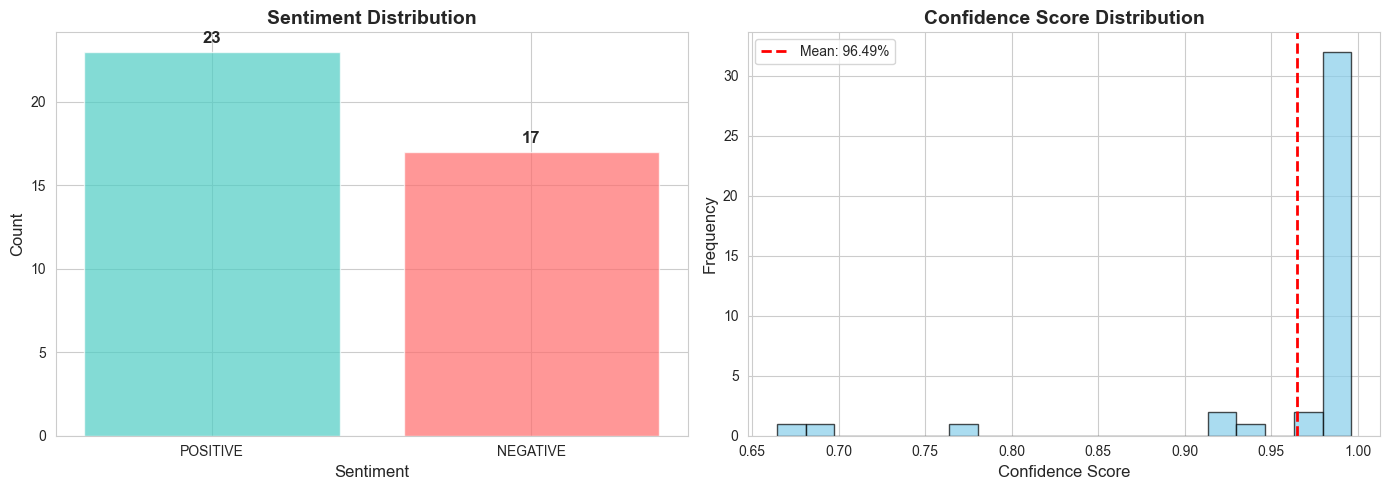


💬 WANT TO TEST YOUR OWN CONVERSATION?

Add your text to the 'test_conversations' list above and re-run!
Or use this code in a new cell:

# Test your own conversation
my_text = "Your text here"
result = classifier(my_text)[0]
print(f"Sentiment: {result['label']}")
print(f"Confidence: {result['score']:.2%}")


✅ ALL DONE!


In [1]:
# ==========================================
# Test Fine-tuned RoBERTa on Human Conversations
# ==========================================

from transformers import pipeline
import torch
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("Testing Fine-tuned RoBERTa on Human Conversations")
print("="*70)

# ==========================================
# Load Fine-tuned Model
# ==========================================
print("\n📥 Loading your fine-tuned RoBERTa model...")

device = 0 if torch.cuda.is_available() else -1  # 0 = GPU, -1 = CPU

# Load your fine-tuned model
classifier = pipeline(
    'sentiment-analysis',
    model='./fine_tuned_roberta',
    device=device
)

if device == 0:
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("✓ Using CPU")

print("✓ Fine-tuned model loaded successfully!")

# ==========================================
# Test Conversations - Add Your Own Here!
# ==========================================

print("\n" + "="*70)
print("🗣️ TESTING ON HUMAN CONVERSATIONS")
print("="*70)

# Add your conversations here
test_conversations = [
    # Positive conversations
    "Hey! I just got the job! I'm so excited and happy!",
    "This movie was absolutely amazing! Best film I've seen this year!",
    "Thank you so much for your help! You're the best!",
    "I love spending time with you. You always make me smile.",
    "Just finished my project and it turned out great! Feeling proud!",
    "The weather is beautiful today! Perfect for a walk in the park.",
    "I'm so grateful for all the support from my friends and family.",
    "This restaurant has the best food ever! Highly recommend it!",
    "I passed my exam! All that hard work paid off!",
    "What a wonderful day! Everything went perfectly.",

    # Negative conversations
    "I'm so frustrated with this terrible service. Never coming back.",
    "This is the worst product I've ever bought. Complete waste of money.",
    "I hate waiting in long queues. This is so annoying!",
    "Feeling really sad and disappointed today. Nothing is going right.",
    "The customer support was rude and unhelpful. Very bad experience.",
    "I'm exhausted and stressed out. Can't handle this anymore.",
    "This traffic is driving me crazy! I'm going to be late again.",
    "I don't like this weather. It's too cold and gloomy.",
    "My order arrived damaged and they won't refund it. So angry!",
    "I'm tired of dealing with these constant problems.",

    # Neutral/Mixed conversations
    "The meeting is scheduled for 3 PM tomorrow.",
    "I think we should consider both options before deciding.",
    "The product is okay, nothing special but it works fine.",
    "I'm not sure how I feel about this yet. Need more time to think.",
    "It's an average experience. Some good points, some bad.",

    # Casual conversations
    "What are you doing this weekend?",
    "Did you watch the game last night?",
    "Hey, long time no see! How have you been?",
    "I might go to the gym later, not sure yet.",
    "Coffee? Sure, I'm free around noon.",

    # Social media style
    "Just had the best vacation ever! 😊 #blessed #happy",
    "Ugh, another Monday morning 😞 #tired #needcoffee",
    "Can't believe this happened! I'm so done!",
    "Living my best life! Everything is going great! 🎉",
    "Why do bad things always happen to me? 😢",

    # Customer reviews style
    "Great product! Fast shipping and excellent quality. 5 stars!",
    "Terrible experience. Product broke after 2 days. Don't buy!",
    "Decent purchase. Does what it's supposed to do. Worth the price.",
    "Amazing customer service! They resolved my issue quickly.",
    "Not worth the money. Expected better quality for this price.",
]

# ==========================================
# Make Predictions
# ==========================================

print(f"\n🔮 Analyzing {len(test_conversations)} conversations...\n")

results = []

for i, conversation in enumerate(test_conversations, 1):
    # Get prediction
    prediction = classifier(conversation)[0]
    label = prediction['label']
    score = prediction['score']

    # Convert to readable format
    if 'LABEL_0' in label or label == '0' or 'negative' in label.lower():
        sentiment = "😞 Negative"
        sentiment_text = "NEGATIVE"
    else:
        sentiment = "😊 Positive"
        sentiment_text = "POSITIVE"

    # Store result
    results.append({
        'conversation': conversation,
        'sentiment': sentiment_text,
        'confidence': score
    })

    # Print result
    print(f"[{i}/{len(test_conversations)}] {sentiment} ({score:.2%} confidence)")
    print(f"    💬 \"{conversation[:80]}{'...' if len(conversation) > 80 else ''}\"")
    print()

# ==========================================
# Summary Statistics
# ==========================================

import pandas as pd

df_results = pd.DataFrame(results)

print("="*70)
print("📊 SUMMARY STATISTICS")
print("="*70)

positive_count = (df_results['sentiment'] == 'POSITIVE').sum()
negative_count = (df_results['sentiment'] == 'NEGATIVE').sum()
avg_confidence = df_results['confidence'].mean()

print(f"\nTotal conversations analyzed: {len(test_conversations)}")
print(f"😊 Positive: {positive_count} ({positive_count/len(test_conversations)*100:.1f}%)")
print(f"😞 Negative: {negative_count} ({negative_count/len(test_conversations)*100:.1f}%)")
print(f"📈 Average confidence: {avg_confidence:.2%}")

# ==========================================
# Most Confident Predictions
# ==========================================

print("\n" + "="*70)
print("🎯 TOP 5 MOST CONFIDENT PREDICTIONS")
print("="*70)

top_confident = df_results.nlargest(5, 'confidence')

for idx, row in top_confident.iterrows():
    emoji = "😊" if row['sentiment'] == 'POSITIVE' else "😞"
    print(f"\n{emoji} {row['sentiment']} - {row['confidence']:.2%} confidence")
    print(f"   💬 \"{row['conversation'][:100]}{'...' if len(row['conversation']) > 100 else ''}\"")

# ==========================================
# Least Confident Predictions (Ambiguous)
# ==========================================

print("\n" + "="*70)
print("🤔 TOP 5 LEAST CONFIDENT PREDICTIONS (Most Ambiguous)")
print("="*70)

least_confident = df_results.nsmallest(5, 'confidence')

for idx, row in least_confident.iterrows():
    emoji = "😊" if row['sentiment'] == 'POSITIVE' else "😞"
    print(f"\n{emoji} {row['sentiment']} - {row['confidence']:.2%} confidence")
    print(f"   💬 \"{row['conversation'][:100]}{'...' if len(row['conversation']) > 100 else ''}\"")

# ==========================================
# Save Results
# ==========================================

print("\n" + "="*70)
print("💾 SAVING RESULTS")
print("="*70)

df_results.to_csv('conversation_analysis_results.csv', index=False)
print("✓ Results saved to: conversation_analysis_results.csv")

# ==========================================
# Visualization
# ==========================================

print("\n📊 Creating visualizations...")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Sentiment Distribution
sentiment_counts = df_results['sentiment'].value_counts()
colors = ['#FF6B6B' if s == 'NEGATIVE' else '#4ECDC4' for s in sentiment_counts.index]
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.7)
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for i, (sentiment, count) in enumerate(sentiment_counts.items()):
    axes[0].text(i, count + 0.5, str(count), ha='center', fontsize=12, fontweight='bold')

# 2. Confidence Distribution
axes[1].hist(df_results['confidence'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Confidence Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].axvline(avg_confidence, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {avg_confidence:.2%}')
axes[1].legend()

plt.tight_layout()
plt.savefig('conversation_sentiment_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as: conversation_sentiment_analysis.png")
plt.show()

# ==========================================
# Interactive Testing
# ==========================================

print("\n" + "="*70)
print("💬 WANT TO TEST YOUR OWN CONVERSATION?")
print("="*70)
print("\nAdd your text to the 'test_conversations' list above and re-run!")
print("Or use this code in a new cell:")
print("""
# Test your own conversation
my_text = "Your text here"
result = classifier(my_text)[0]
print(f"Sentiment: {result['label']}")
print(f"Confidence: {result['score']:.2%}")
""")

print("\n" + "="*70)
print("✅ ALL DONE!")
print("="*70)